# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

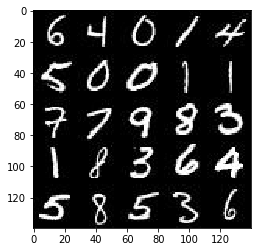

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

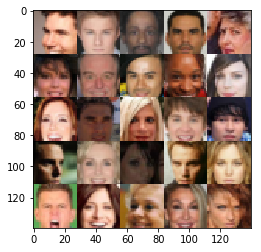

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # first dim is batch size, second is data size
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32,None,name="learning_rate")
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha : leaky relu rate
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        r1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(r1, 128, 5, strides=2, padding="same")
        b2 = tf.layers.batch_normalization(x2, training=True)
        r2 = tf.maximum(alpha * b2, b2)

        x3 = tf.layers.conv2d(r2, 256, 5, strides=2, padding="same")
        b3 = tf.layers.batch_normalization(x3, training=True)
        r3 = tf.maximum(alpha * b3, b3)

        flat = tf.reshape(r3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        #print("x1:{}".format(x1.get_shape()),
        #      "x2:{}".format(x2.get_shape()),
        #      "x3:{}".format(x3.get_shape()),
        #      "fl:{}".format(flat.get_shape()),
        #     )

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha : leaky relu rate
    :return: The tensor output of the generator
    """
    # set reuse condition
    if is_train:
        # don't reuse when training
        reuse = False
    else:
        # reuse when inferring
        reuse = True

    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        # size is multipled by 7 * 7 to get image dimensions 28x28 instead of 32x32
        # this took some experimentation to get it to work. I am a bit weak on
        # visualizing the shape of tensors
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        b1 = tf.layers.batch_normalization(x1, training=is_train)
        r1 = tf.maximum(alpha * b1, b1)

        # strides is 1 here to keep sizes correct
        x2 = tf.layers.conv2d_transpose(r1, 256, 5, strides=1, padding='same')
        b2 = tf.layers.batch_normalization(x2, training=is_train)
        r2 = tf.maximum(alpha * b2, b2)

        x3 = tf.layers.conv2d_transpose(r2, 128, 5, strides=2, padding='same')
        b3 = tf.layers.batch_normalization(x3, training=is_train)
        r3 = tf.maximum(alpha * b3, b3)

        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(r3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)


Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # same as in DCGAN exercise
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # same as in DCGAN exercise, plus some reformating
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    model_inputs(image_width, image_height, image_channels, z_dim)
    model_loss(input_real, input_z, out_channel_dim)
    model_opt(d_loss, g_loss, learning_rate, beta1)
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    inputs_real, inputs_z, lrate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 20
    show_every  = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # batch count
                steps += 1

                # this improved the results however I am not clear on how
                # I saw it in some of the forum questions. it was used in
                # previous project for scaling the data but the dataset
                # object for this project was supposed to perform the scaling
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lrate:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lrate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}/{}...".format(epoch_i + 1, epochs,steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    # determine image dimension (this way was more clear to me than grabbing a shape index)
                    if data_image_mode == "L":
                        output_channel_dim = 1
                    else:
                        output_channel_dim = 3
                    show_generator_output(sess, 9, inputs_z, output_channel_dim, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2/20... Discriminator Loss: 0.9353... Generator Loss: 3.1452
Epoch 1/2/40... Discriminator Loss: 1.1520... Generator Loss: 2.1886
Epoch 1/2/60... Discriminator Loss: 1.8949... Generator Loss: 3.2570
Epoch 1/2/80... Discriminator Loss: 1.1629... Generator Loss: 1.4498
Epoch 1/2/100... Discriminator Loss: 1.3116... Generator Loss: 1.4138


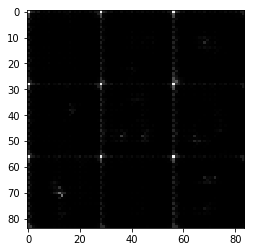

Epoch 1/2/120... Discriminator Loss: 1.4692... Generator Loss: 1.0133
Epoch 1/2/140... Discriminator Loss: 1.8303... Generator Loss: 0.3009
Epoch 1/2/160... Discriminator Loss: 1.3801... Generator Loss: 0.4465
Epoch 1/2/180... Discriminator Loss: 1.2989... Generator Loss: 0.6647
Epoch 1/2/200... Discriminator Loss: 1.5130... Generator Loss: 0.4046


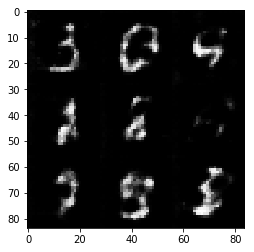

Epoch 1/2/220... Discriminator Loss: 1.2864... Generator Loss: 1.0793
Epoch 1/2/240... Discriminator Loss: 1.2302... Generator Loss: 0.8532
Epoch 1/2/260... Discriminator Loss: 1.1914... Generator Loss: 0.8518
Epoch 1/2/280... Discriminator Loss: 1.2984... Generator Loss: 0.7126
Epoch 1/2/300... Discriminator Loss: 1.3792... Generator Loss: 0.4199


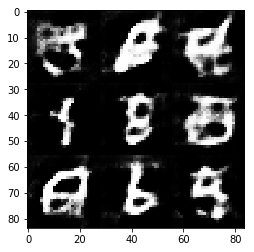

Epoch 1/2/320... Discriminator Loss: 1.4771... Generator Loss: 1.3645
Epoch 1/2/340... Discriminator Loss: 1.3520... Generator Loss: 0.4378
Epoch 1/2/360... Discriminator Loss: 1.2562... Generator Loss: 0.9152
Epoch 1/2/380... Discriminator Loss: 1.2448... Generator Loss: 1.0201
Epoch 1/2/400... Discriminator Loss: 1.2368... Generator Loss: 1.0556


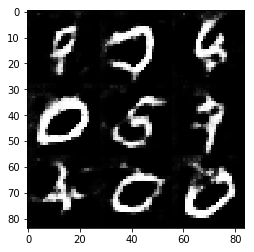

Epoch 1/2/420... Discriminator Loss: 1.2018... Generator Loss: 0.7970
Epoch 1/2/440... Discriminator Loss: 1.3470... Generator Loss: 1.2894
Epoch 1/2/460... Discriminator Loss: 1.2018... Generator Loss: 1.0901
Epoch 1/2/480... Discriminator Loss: 1.5287... Generator Loss: 0.3727
Epoch 1/2/500... Discriminator Loss: 1.2030... Generator Loss: 1.1454


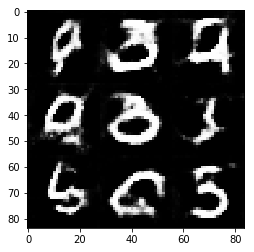

Epoch 1/2/520... Discriminator Loss: 1.2455... Generator Loss: 0.8353
Epoch 1/2/540... Discriminator Loss: 1.1704... Generator Loss: 1.0085
Epoch 1/2/560... Discriminator Loss: 1.2260... Generator Loss: 1.2602
Epoch 1/2/580... Discriminator Loss: 1.4781... Generator Loss: 0.4568
Epoch 1/2/600... Discriminator Loss: 1.0853... Generator Loss: 0.8035


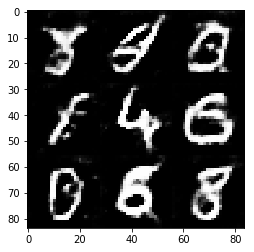

Epoch 2/2/620... Discriminator Loss: 1.4428... Generator Loss: 0.3626
Epoch 2/2/640... Discriminator Loss: 1.4386... Generator Loss: 1.3378
Epoch 2/2/660... Discriminator Loss: 1.2355... Generator Loss: 0.4588
Epoch 2/2/680... Discriminator Loss: 1.5538... Generator Loss: 0.2957
Epoch 2/2/700... Discriminator Loss: 2.5326... Generator Loss: 2.8926


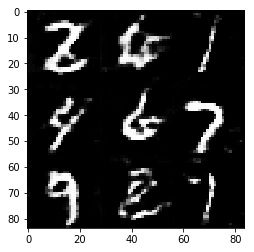

Epoch 2/2/720... Discriminator Loss: 1.1698... Generator Loss: 0.5675
Epoch 2/2/740... Discriminator Loss: 0.9962... Generator Loss: 0.7166
Epoch 2/2/760... Discriminator Loss: 0.9904... Generator Loss: 0.9066
Epoch 2/2/780... Discriminator Loss: 1.0413... Generator Loss: 0.8023
Epoch 2/2/800... Discriminator Loss: 1.1833... Generator Loss: 1.4089


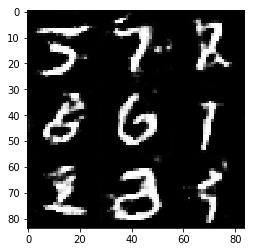

Epoch 2/2/820... Discriminator Loss: 1.1162... Generator Loss: 1.6572
Epoch 2/2/840... Discriminator Loss: 1.2171... Generator Loss: 1.3149
Epoch 2/2/860... Discriminator Loss: 1.2831... Generator Loss: 0.4833
Epoch 2/2/880... Discriminator Loss: 0.9021... Generator Loss: 1.1382
Epoch 2/2/900... Discriminator Loss: 1.2034... Generator Loss: 0.6561


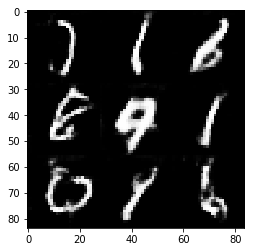

Epoch 2/2/920... Discriminator Loss: 1.1836... Generator Loss: 0.7668
Epoch 2/2/940... Discriminator Loss: 1.1726... Generator Loss: 0.5101
Epoch 2/2/960... Discriminator Loss: 1.1245... Generator Loss: 0.9461
Epoch 2/2/980... Discriminator Loss: 1.2187... Generator Loss: 1.7773
Epoch 2/2/1000... Discriminator Loss: 1.0212... Generator Loss: 0.7250


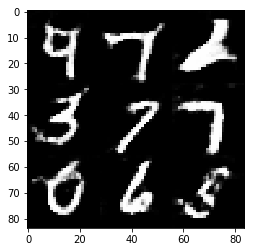

Epoch 2/2/1020... Discriminator Loss: 1.1333... Generator Loss: 0.7189
Epoch 2/2/1040... Discriminator Loss: 1.1092... Generator Loss: 0.5968
Epoch 2/2/1060... Discriminator Loss: 0.9362... Generator Loss: 0.9910
Epoch 2/2/1080... Discriminator Loss: 2.0347... Generator Loss: 2.6356
Epoch 2/2/1100... Discriminator Loss: 1.2906... Generator Loss: 0.5005


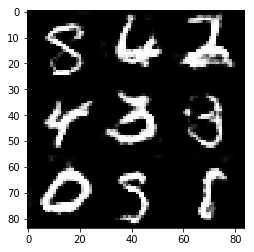

Epoch 2/2/1120... Discriminator Loss: 0.7836... Generator Loss: 1.3664
Epoch 2/2/1140... Discriminator Loss: 0.9871... Generator Loss: 0.9702
Epoch 2/2/1160... Discriminator Loss: 1.1831... Generator Loss: 0.5816
Epoch 2/2/1180... Discriminator Loss: 1.2346... Generator Loss: 1.2977
Epoch 2/2/1200... Discriminator Loss: 0.8365... Generator Loss: 1.4489


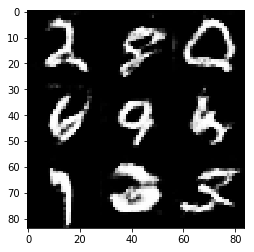

In [12]:
batch_size = 100

# a z_dim of 200 failed horribly
z_dim = 100

# learning rate of 0.0002 had worse results at least with this batch size
learning_rate = 0.001

# ! the model was very sensitive to the beta1 parameter
# ! small variations in beta1 caused the model to fail to converge
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1/20... Discriminator Loss: 0.1090... Generator Loss: 6.7675
Epoch 1/1/40... Discriminator Loss: 0.3912... Generator Loss: 2.9694
Epoch 1/1/60... Discriminator Loss: 0.2063... Generator Loss: 5.1803
Epoch 1/1/80... Discriminator Loss: 0.3993... Generator Loss: 1.5071
Epoch 1/1/100... Discriminator Loss: 0.0494... Generator Loss: 5.5670


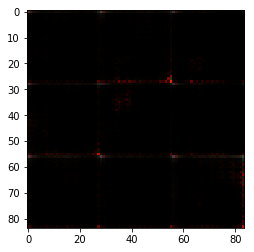

Epoch 1/1/120... Discriminator Loss: 0.4009... Generator Loss: 1.5667
Epoch 1/1/140... Discriminator Loss: 0.9241... Generator Loss: 0.7627
Epoch 1/1/160... Discriminator Loss: 0.9506... Generator Loss: 2.0044
Epoch 1/1/180... Discriminator Loss: 1.1103... Generator Loss: 0.6512
Epoch 1/1/200... Discriminator Loss: 1.5884... Generator Loss: 2.5637


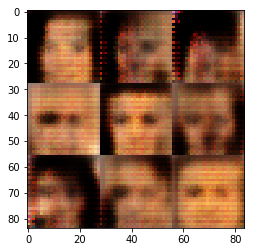

Epoch 1/1/220... Discriminator Loss: 1.8353... Generator Loss: 0.2244
Epoch 1/1/240... Discriminator Loss: 1.4773... Generator Loss: 0.3759
Epoch 1/1/260... Discriminator Loss: 0.6785... Generator Loss: 2.6815
Epoch 1/1/280... Discriminator Loss: 0.9203... Generator Loss: 4.3591
Epoch 1/1/300... Discriminator Loss: 0.4944... Generator Loss: 1.3888


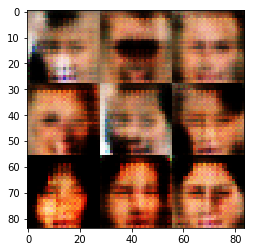

Epoch 1/1/320... Discriminator Loss: 0.2606... Generator Loss: 2.5970
Epoch 1/1/340... Discriminator Loss: 0.0438... Generator Loss: 3.5555
Epoch 1/1/360... Discriminator Loss: 0.7544... Generator Loss: 1.2975
Epoch 1/1/380... Discriminator Loss: 0.3070... Generator Loss: 1.8945
Epoch 1/1/400... Discriminator Loss: 1.0481... Generator Loss: 4.8534


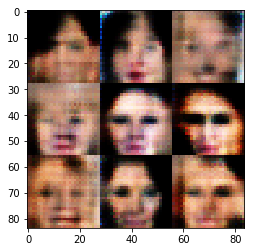

Epoch 1/1/420... Discriminator Loss: 1.1864... Generator Loss: 2.0647
Epoch 1/1/440... Discriminator Loss: 0.5057... Generator Loss: 1.3770
Epoch 1/1/460... Discriminator Loss: 0.6430... Generator Loss: 1.8592
Epoch 1/1/480... Discriminator Loss: 0.7126... Generator Loss: 0.8862
Epoch 1/1/500... Discriminator Loss: 0.4591... Generator Loss: 1.3295


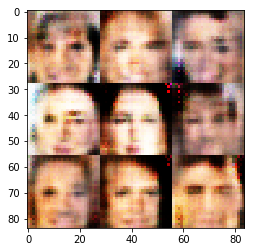

Epoch 1/1/520... Discriminator Loss: 1.3724... Generator Loss: 0.3812
Epoch 1/1/540... Discriminator Loss: 0.2272... Generator Loss: 2.7256
Epoch 1/1/560... Discriminator Loss: 0.2066... Generator Loss: 2.1136
Epoch 1/1/580... Discriminator Loss: 0.6115... Generator Loss: 1.1449
Epoch 1/1/600... Discriminator Loss: 0.6102... Generator Loss: 1.2612


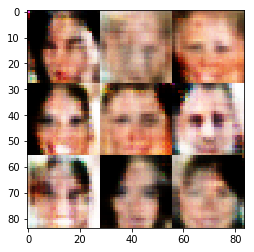

Epoch 1/1/620... Discriminator Loss: 1.0332... Generator Loss: 1.1742
Epoch 1/1/640... Discriminator Loss: 0.8541... Generator Loss: 0.9476
Epoch 1/1/660... Discriminator Loss: 1.5607... Generator Loss: 0.3673
Epoch 1/1/680... Discriminator Loss: 2.5942... Generator Loss: 5.1127
Epoch 1/1/700... Discriminator Loss: 1.1064... Generator Loss: 0.5684


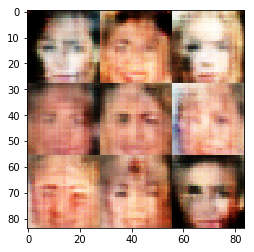

Epoch 1/1/720... Discriminator Loss: 1.0076... Generator Loss: 1.4275
Epoch 1/1/740... Discriminator Loss: 0.7975... Generator Loss: 2.2258
Epoch 1/1/760... Discriminator Loss: 0.4495... Generator Loss: 1.9125
Epoch 1/1/780... Discriminator Loss: 0.9071... Generator Loss: 0.6546
Epoch 1/1/800... Discriminator Loss: 0.3613... Generator Loss: 1.5028


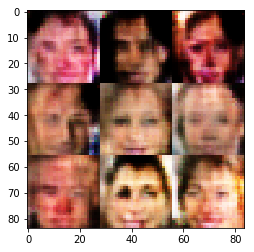

Epoch 1/1/820... Discriminator Loss: 1.4070... Generator Loss: 2.5996
Epoch 1/1/840... Discriminator Loss: 0.5906... Generator Loss: 1.1197
Epoch 1/1/860... Discriminator Loss: 1.1452... Generator Loss: 0.5752
Epoch 1/1/880... Discriminator Loss: 0.9722... Generator Loss: 0.8088
Epoch 1/1/900... Discriminator Loss: 1.2099... Generator Loss: 0.4455


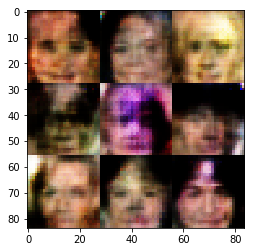

Epoch 1/1/920... Discriminator Loss: 1.7309... Generator Loss: 1.6926
Epoch 1/1/940... Discriminator Loss: 1.1978... Generator Loss: 0.5337
Epoch 1/1/960... Discriminator Loss: 1.8566... Generator Loss: 4.2283
Epoch 1/1/980... Discriminator Loss: 0.5370... Generator Loss: 1.4142
Epoch 1/1/1000... Discriminator Loss: 1.3318... Generator Loss: 0.4239


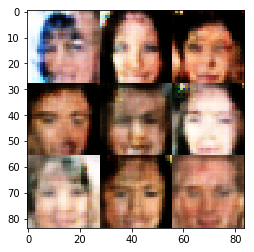

Epoch 1/1/1020... Discriminator Loss: 0.8898... Generator Loss: 1.1407
Epoch 1/1/1040... Discriminator Loss: 0.6625... Generator Loss: 1.1567
Epoch 1/1/1060... Discriminator Loss: 0.6418... Generator Loss: 1.0947
Epoch 1/1/1080... Discriminator Loss: 0.9806... Generator Loss: 4.2455
Epoch 1/1/1100... Discriminator Loss: 1.7370... Generator Loss: 0.2766


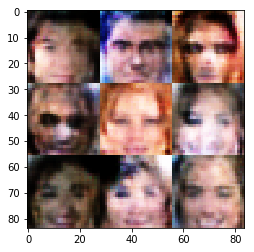

Epoch 1/1/1120... Discriminator Loss: 0.9898... Generator Loss: 1.1383
Epoch 1/1/1140... Discriminator Loss: 0.5351... Generator Loss: 2.4498
Epoch 1/1/1160... Discriminator Loss: 0.7752... Generator Loss: 1.3468
Epoch 1/1/1180... Discriminator Loss: 1.7009... Generator Loss: 2.7975
Epoch 1/1/1200... Discriminator Loss: 1.4120... Generator Loss: 5.8553


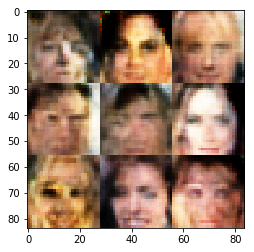

Epoch 1/1/1220... Discriminator Loss: 0.0872... Generator Loss: 3.2101
Epoch 1/1/1240... Discriminator Loss: 0.8762... Generator Loss: 3.3666
Epoch 1/1/1260... Discriminator Loss: 0.0474... Generator Loss: 4.8767
Epoch 1/1/1280... Discriminator Loss: 0.1198... Generator Loss: 3.0733
Epoch 1/1/1300... Discriminator Loss: 0.5654... Generator Loss: 1.9105


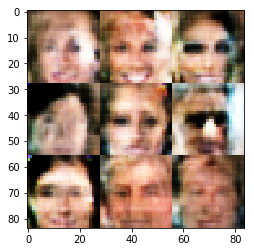

Epoch 1/1/1320... Discriminator Loss: 1.0415... Generator Loss: 0.5456
Epoch 1/1/1340... Discriminator Loss: 0.9569... Generator Loss: 0.7700
Epoch 1/1/1360... Discriminator Loss: 0.5366... Generator Loss: 1.2429
Epoch 1/1/1380... Discriminator Loss: 1.8319... Generator Loss: 0.2603
Epoch 1/1/1400... Discriminator Loss: 0.5987... Generator Loss: 1.0677


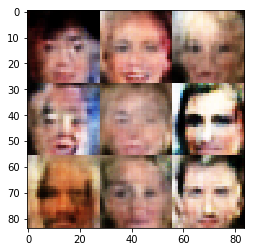

Epoch 1/1/1420... Discriminator Loss: 2.2140... Generator Loss: 0.1591
Epoch 1/1/1440... Discriminator Loss: 0.8715... Generator Loss: 0.6640
Epoch 1/1/1460... Discriminator Loss: 0.0979... Generator Loss: 3.5986
Epoch 1/1/1480... Discriminator Loss: 0.1355... Generator Loss: 3.5927
Epoch 1/1/1500... Discriminator Loss: 0.5468... Generator Loss: 1.1062


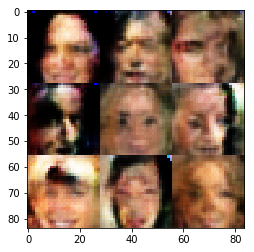

Epoch 1/1/1520... Discriminator Loss: 1.2452... Generator Loss: 0.4733
Epoch 1/1/1540... Discriminator Loss: 0.1691... Generator Loss: 3.5046
Epoch 1/1/1560... Discriminator Loss: 0.3253... Generator Loss: 1.6802
Epoch 1/1/1580... Discriminator Loss: 0.2923... Generator Loss: 2.5951
Epoch 1/1/1600... Discriminator Loss: 0.6834... Generator Loss: 1.5929


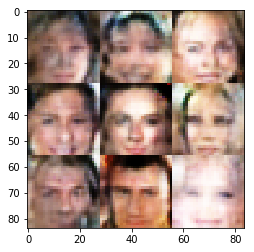

Epoch 1/1/1620... Discriminator Loss: 1.7863... Generator Loss: 0.3294
Epoch 1/1/1640... Discriminator Loss: 0.4379... Generator Loss: 2.3990
Epoch 1/1/1660... Discriminator Loss: 0.4140... Generator Loss: 1.4441
Epoch 1/1/1680... Discriminator Loss: 1.0947... Generator Loss: 2.8074
Epoch 1/1/1700... Discriminator Loss: 1.8353... Generator Loss: 0.2323


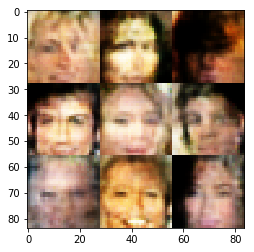

Epoch 1/1/1720... Discriminator Loss: 0.4239... Generator Loss: 1.3160
Epoch 1/1/1740... Discriminator Loss: 0.1341... Generator Loss: 3.2244
Epoch 1/1/1760... Discriminator Loss: 1.1942... Generator Loss: 0.6181
Epoch 1/1/1780... Discriminator Loss: 1.5331... Generator Loss: 2.8777
Epoch 1/1/1800... Discriminator Loss: 0.5073... Generator Loss: 1.4103


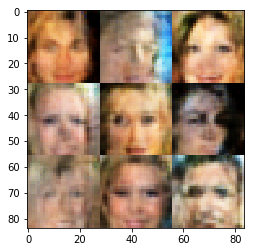

Epoch 1/1/1820... Discriminator Loss: 1.5327... Generator Loss: 0.3692
Epoch 1/1/1840... Discriminator Loss: 0.7784... Generator Loss: 1.9257
Epoch 1/1/1860... Discriminator Loss: 1.7318... Generator Loss: 3.3505
Epoch 1/1/1880... Discriminator Loss: 0.2786... Generator Loss: 1.7486
Epoch 1/1/1900... Discriminator Loss: 1.1467... Generator Loss: 0.6830


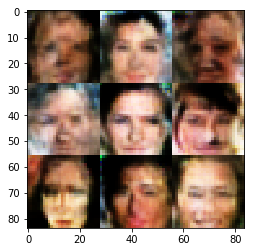

Epoch 1/1/1920... Discriminator Loss: 1.0444... Generator Loss: 3.3363
Epoch 1/1/1940... Discriminator Loss: 0.4015... Generator Loss: 1.3116
Epoch 1/1/1960... Discriminator Loss: 1.1458... Generator Loss: 0.6841
Epoch 1/1/1980... Discriminator Loss: 2.1006... Generator Loss: 0.1947
Epoch 1/1/2000... Discriminator Loss: 0.3384... Generator Loss: 2.4899


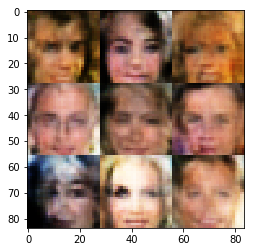

Epoch 1/1/2020... Discriminator Loss: 0.8526... Generator Loss: 0.8882


In [13]:
batch_size = 100

# a z_dim of 200 failed horribly
z_dim = 100

# learning rate of 0.0002 had worse results at least with this batch size
learning_rate = 0.001

# ! the model was very sensitive to the beta1 parameter
# ! small variations in beta1 caused the model to fail to converge
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.